In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
import json
import io
from PIL import Image, ImageDraw
import yaml

In [14]:
class RndDataloader(Dataset):

    def __init__(self, folder_path, class_path, root: str=None, train=True, transform=None, target_transform = None,split : float = 0.5)-> None:
        super().__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.folder_path = folder_path
        self.json_files, self.json_data  = self.load_data()

        with open(class_path, 'r') as file:
            self.classes = yaml.safe_load(file)

    def __len__(self):
        return len(self.folder_path)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.json_files.iloc[idx,1])
        img, base_path = self.get_image(img_path)
        label = self.json_data[self.json_data['image'] == base_path]['label']

        print("image path: ", img_path)
        print("image name: ", base_path)
        print("labels: \n", label)

        if self.transform:
            img_transform = self.transform(img)
        if self.target_transform:
            label_transform = self.target_transform(label)

        points = np.array(self.get_points(base_path, img.size, img_transform.shape))

        return img_transform, label_transform, points

    def get_image(self, img_path):
        base_path = os.path.basename(img_path)
        img = Image.open(img_path)
        return img, base_path

    def get_points(self,base_path, img_size, img_transform_size):
        points = np.array(self.json_data[self.json_data['image'] == base_path]['points'].tolist())
        og_height, og_width = img_size
        _, tr_width, tr_height = img_transform_size
        scaling_x, scaling_y = tr_height/og_height, tr_width/og_width
        transformed_points = [[x * scaling_x, y * scaling_y] for x, y in points]

        return transformed_points

    def load_data(self):
        folder_path = self.folder_path
        j_files = []
        j_data = []
        for file in os.listdir(folder_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(folder_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    j_files.append({'json_path':json_path, 'image_path':file})
                    ## Implemented Pandas here instead of json load ##
                    for item in json_load['shapes']:
                        j_data.append({'image': json_load['imagePath'],
                                     'label': item['label'],
                                     'points': item['points']})
        json_data = pd.DataFrame(j_data)
        json_files = pd.DataFrame(j_files)
        return json_files, json_data

In [15]:
# absolute paths needs to be given for RndDataloader

folder_path = '../dataset/sample/sample_set_annotated'
yaml_path = '../config/class.yaml'

with open(yaml_path, 'r') as file:
            classes = yaml.safe_load(file)

In [16]:
transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def target_transform(labels):
    target = np.zeros(len(classes), dtype=int)
    for label in labels:
        if label in classes:
            index = classes[label]
            target[index] = 1

    return target

In [17]:
rndloader = RndDataloader(folder_path=folder_path, class_path=yaml_path,
                          train=True, transform=transform,
                        target_transform=target_transform)
# rndloader.json_data

image path:  ../dataset/sample/sample_set_annotated/rnD_robocup_012.jpg
image name:  rnD_robocup_012.jpg
labels: 
 15    S40_40_B
16    S40_40_G
17    F20_20_B
Name: label, dtype: object


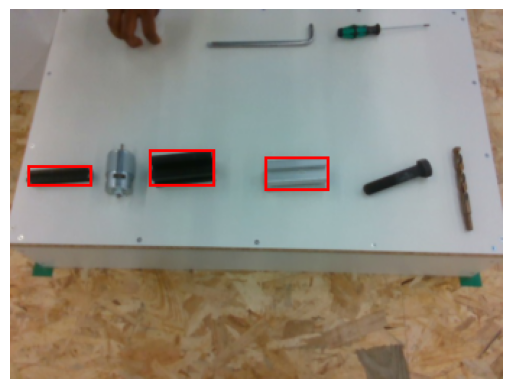

image shape:  torch.Size([3, 256, 341])
transformed labels:  [0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0]
transformed points:  [[[ 96.971875    97.5046875 ]
  [141.86666667 122.66666667]]

 [[176.3609375  102.8328125 ]
  [220.26666667 125.86666667]]

 [[ 12.2546875  108.69375   ]
  [ 56.53333333 122.13333333]]]


In [18]:
sample_indices = [4]

image, label, points = None, None, None
for index in sample_indices:
    image, label, points = rndloader[index]

    img = transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(img)
    for box in points:
        draw.rectangle([box[0][0], box[0][1], box[1][0], box[1][1]], outline ="red", width=2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

print("image shape: ", image.shape)
print("transformed labels: ", label)
print("transformed points: ", points)


### transformed_label one-hot encoding based on config/class.yaml file